In [ ]:
!nvidia-smi

Tue Feb  7 11:36:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |   1778MiB /  2048MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2996846242452572785
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1225944676
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18166989647878258434
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [70]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight 

import cv2
from PIL import Image
#Base
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import Image, display
import matplotlib.cm as cm

import pydot
import pydotplus
from pydotplus import graphviz


import warnings
warnings.filterwarnings("ignore")


In [61]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')

# Image generator

In [64]:
batch_size = 32 # Batch size

train_path = './train'
test_path = './test' 

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [4]:
train_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='training',
        class_mode='categorical')

Found 23524 images belonging to 3 classes.


In [5]:
validation_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='validation',
        class_mode='categorical')

Found 5880 images belonging to 3 classes.


In [65]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 397 images belonging to 3 classes.


In [6]:
train_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [7]:
validation_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [8]:
test_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

## Class Weights

**Class_weight**: can be used to make the model learn more from the minority class (a higher penalty is added when the network errs on the minority class)

In [8]:
class_weights = class_weight.compute_class_weight(
            class_weight= 'balanced',
            classes = np.unique(train_data.classes), 
            y = train_data.classes)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

{0: 0.6213417855256207, 1: 1.212327355184498, 2: 1.76765855124737}


# Architecture Definition

In [9]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [10]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_cw = keras.Model(inputs, outputs)



In [24]:
net_dcnn_112_cw.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                           

In [13]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2)
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [25]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

735
183


In [26]:
net_dcnn_112_cw.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [ ]:
history_dcnn_cw = net_dcnn_112_cw.fit(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          class_weight = train_class_weights,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

In [28]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_cw.history)

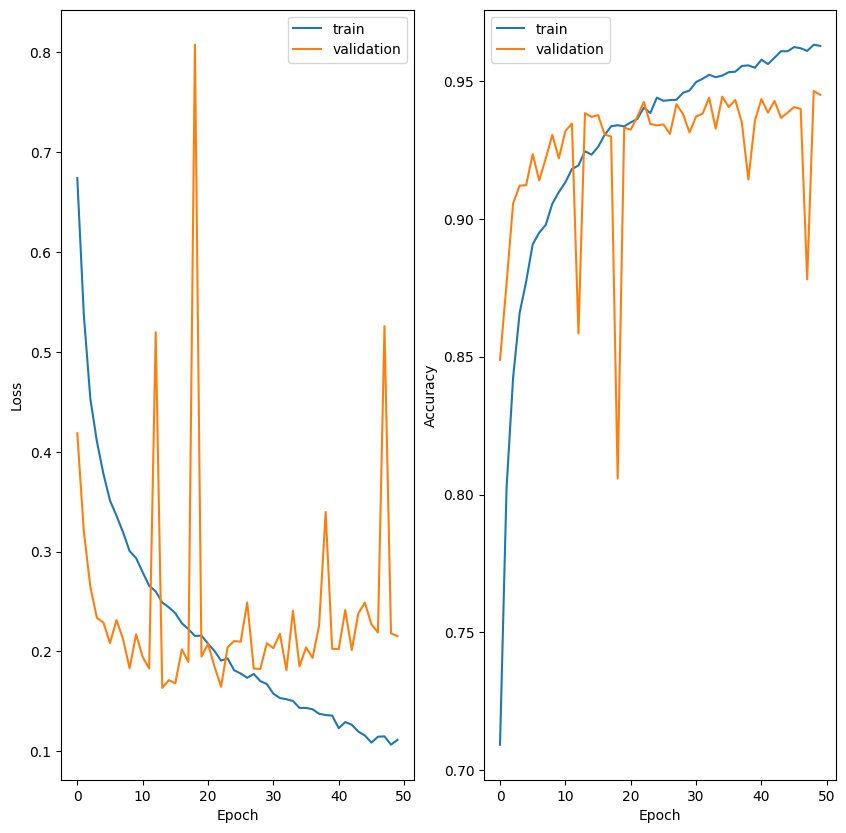

In [30]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_cw.history['loss'])
plt.plot(history_dcnn_cw.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_cw.history['accuracy'])
plt.plot(history_dcnn_cw.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [2]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug')

In [3]:
# Load model
net_dcnn_112_cw = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [36]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

# Model Evaluation

In [26]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [27]:
CATEGORIES = ["COVID", "NORMAL","PNEUMONIA"]

In [28]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][0:index]
    plt.plot(train_values)
    test_values = history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [29]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [30]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [31]:
def model_summary(model, history, name):       
        val_acc = history['val_accuracy'] 
        index= val_acc.index(max(val_acc))
        print('Best Epochs:', index)


        test_loss, test_accuracy, test_precision, test_recall, auc,  _ = model.evaluate(test_data, verbose=1)

        train_accuracy = history['accuracy'][index]
        train_loss = history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)

        print('---'*15) 
        print(name)
        print('> Accuracy on train:',round(train_accuracy, 2), 
                '\tLoss on train:', round(train_loss,2))


        print('> Accuracy on test:',round(test_accuracy, 2),
                '\tLoss on test:',round(test_loss,2))

        print('---'*15)
        print('> predicting test')
        print('---'*15)

        printResults(name, model)

Best Epochs: 48
13/13 [==============================] - 1s 40ms/step - loss: 0.4574 - accuracy: 0.8841 - precision: 0.8861 - recall: 0.8816 - auc: 0.9677 - top k accuracy: 1.0000


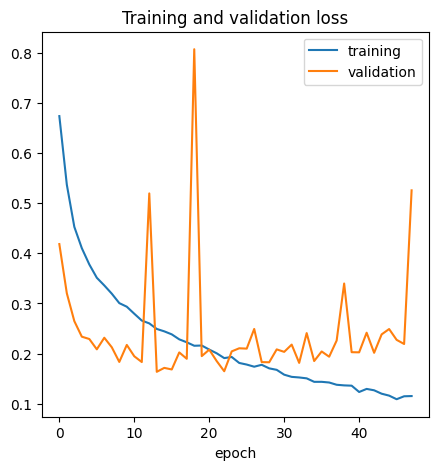

<Figure size 500x500 with 0 Axes>

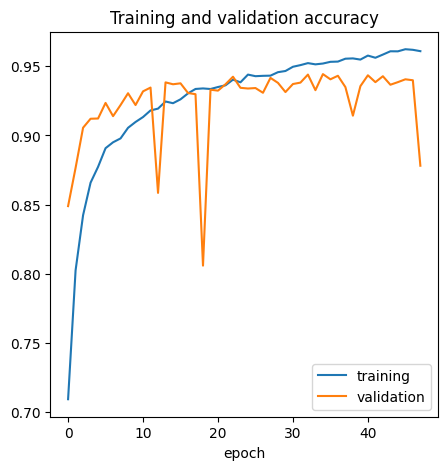

---------------------------------------------
DCCN - Undersampling
> Accuracy on train: 0.96 	Loss on train: 0.11
> Accuracy on test: 0.88 	Loss on test: 0.46
---------------------------------------------
> predicting test
---------------------------------------------
13/13 [==============================] - 1s 40ms/step


<Figure size 500x500 with 0 Axes>

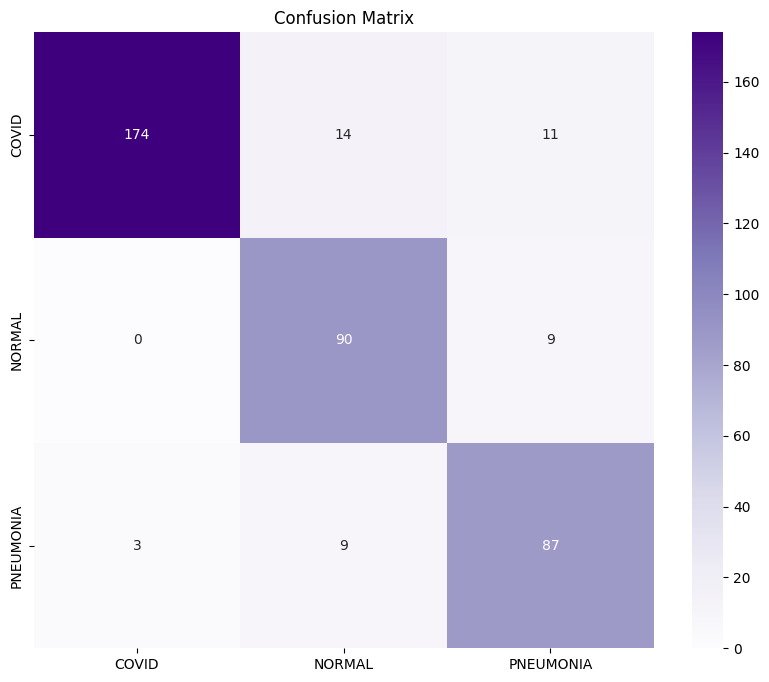

.............................................
> Correct Predictions: 351
> Wrong Predictions: 46
.............................................
              precision    recall  f1-score   support

       COVID       0.98      0.87      0.93       199
      NORMAL       0.80      0.91      0.85        99
   PNEUMONIA       0.81      0.88      0.84        99

    accuracy                           0.88       397
   macro avg       0.86      0.89      0.87       397
weighted avg       0.89      0.88      0.89       397



In [38]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')
model_summary(net_dcnn_112_cw, history, 'DCCN - Undersampling')

# Explainable AI + Demo[OLD]

**Grad-CAM class activation visualization**

Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

In [39]:
net_dcnn_112_cw.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                           

In [169]:
def get_img_array(img_path, size):

    # `Load img
    img = keras.preprocessing.image.load_img(img_path, target_size=size)

    # `Trasform the img to numpy array of shape (w, h, 3)
    array = keras.preprocessing.image.img_to_array(img)

    # Add a dimension to transform the array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array = img_array / 255.0
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [175]:
img_size = (112, 112)

#Name of the last Conv Layer
last_conv_layer_name = "conv2d_7"

# The local path to our target image
img_path = "C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/test/f12d7b12-0398-4533-8f55-8772cc434945.png"
# Load model
net_dcnn_112_cw = keras.models.load_model("C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug/dcnn_model_112_v1_val_acc_best.hdf5")
# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = img_array / 255.0

preds = net_dcnn_112_cw.predict(img_array, verbose=1)

1/1 [==============================] - 0s 104ms/step


In [176]:
if np.argmax(preds, axis=1)==0:
    print('Predicted: COVID-19')
elif np.argmax(preds, axis=1)==1:
    print('Predicted: Normal')
else:
    print('Predicted: Pneumonia')

print('Ground truth: Pneumonia')

Predicted: Pneumonia
Ground truth: Pneumonia


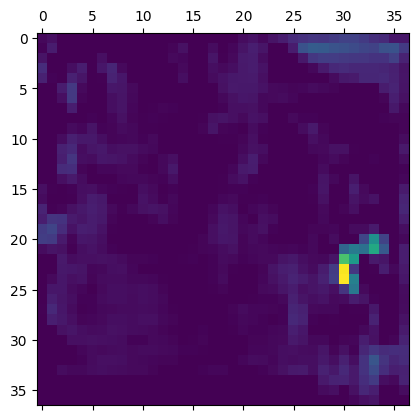

In [177]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, net_dcnn_112_cw, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [173]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, target_size = (400,400))
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)

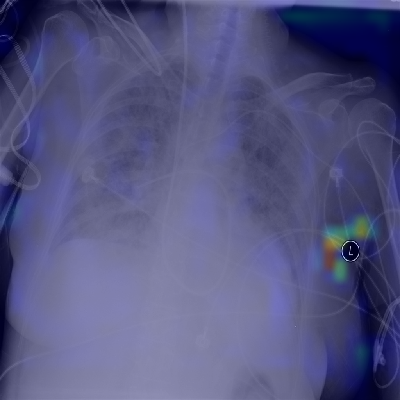

In [178]:
save_and_display_gradcam(img_path, heatmap)